# Machine Learning Dynamical Systems

In [ ]:
### Install dependencies
!pip3.9 install numpy matplotlib scipy
!pip3.9 install tqdm plotly
!pip3.9 install torch torchvision torchaudio
!pip3.9 install optuna
!pip3.9 install pytorch-lightning
!pip3.9 install google


In [1]:
#!/usr/bin/env python3
%matplotlib inline

# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Trainig with lighninig
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
from pytorch_lightning import Callback


# Import models
from models import LSTM, VarFFAE, FFNet, ESN, Transformer
#from pyESN import ESN
from Informer.model import Informer

# Import training and evaluating functions
from training import train
from pi_training import pi_train, tf_train
from plot import gen_trajectory, plt_gen_trajectory

# Import dataset
from dataset import DynSysDataset

# Import callbacks
from callbacks import MetricsCallback

# Import functions for physical informed training
from utils import L63_field, EuDLoss, CeDLoss, Sampler, nKLDivLoss

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
import plotly
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

## Dataset generation

In [2]:
### Datasets
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

dt = 0.01
steps = 10000
seq_len = 100
discard = 1000

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

# Train dataset
state0 = [1.0, 1.0, 1.0]
train_states = DynSysDataset(state0, f, dt, steps, seq_len, discard)
t_train = train_states.time
train_dataset = train_states.dataset

# Validtion dataset
state0 = [2.0, 0.0, 3.0]
val_states =  DynSysDataset(state0, f, dt, steps, seq_len, discard)
t_val = val_states.time
val_dataset = val_states.dataset

# Test dataset
state0 = train_dataset[-1]
test_states =  DynSysDataset(state0, f, dt, steps, seq_len, discard)
t_test = test_states.time
test_dataset = test_states.dataset

### Dataloader
batch_size = 20

train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_states, batch_size=batch_size,num_workers=0, shuffle=True)



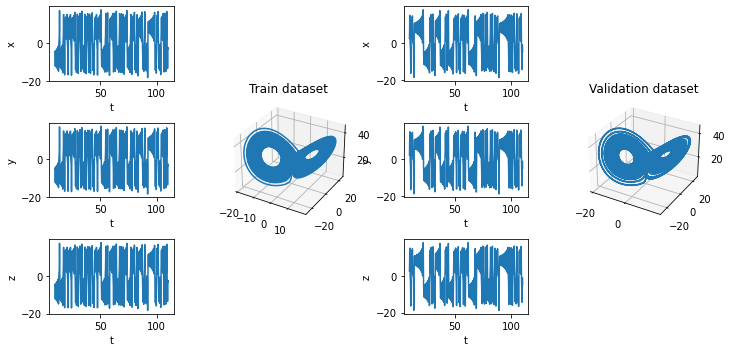

In [3]:
### Plot dataset
fig, axs = plt.subplots(figsize=(10,5), ncols=4, nrows=3)
gs = axs[1, 3].get_gridspec()

index = 0
for ax in axs[0:,0]:
    ax.set_xlabel("t")
    ax.plot(t_train,train_dataset[:, 0])
    index += 1
    
axs[0,0].set_ylabel("x")
axs[1,0].set_ylabel("y")
axs[2,0].set_ylabel("z")



# remove the underlying axes
for ax in axs[0:, 1]:
    ax.remove()
    
axbig1 = fig.add_subplot(gs[0:, 1], projection="3d")
axbig1.set_title("Train dataset")
axbig1.plot(train_dataset[:,0], train_dataset[:,1], train_dataset[:,2])


index = 0
for ax in axs[0:,2]:
    ax.set_xlabel("t")
    ax.plot(t_val,val_dataset[:, 0])
    index += 1
    
axs[0,2].set_ylabel("x")
axs[1,2].set_ylabel("y")
axs[2,2].set_ylabel("z")

# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()

axbig2 = fig.add_subplot(gs[0:, -1], projection="3d")
axbig2.set_title("Validation dataset")
axbig2.plot(val_dataset[:,0], val_dataset[:,1], val_dataset[:,2])


fig.tight_layout()

plt.show()

## Physical Informed dynamics

### LSTM

In [ ]:
### Hyperparameter optmization
#Check if the GPU is available


# Define annealing
max_num_epochs = 2000
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
    
# Define loss function
loss_fn = PILoss(dt,field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0), annealing= [1]*max_num_epochs)

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True)
    hidden_units = trial.suggest_int("hidden_units", 10,200)
    layers_num = trial.suggest_int("layers_num", 2,5)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
   
    # Define network
    input_size = 3
    model = LSTM(input_size, hidden_units, layers_num, drop_p)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
        
    # Train
    max_num_epochs = 100
    early_stopping = False
    train_loss, val_loss = pi_train(model, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
    
    # Metric to be minimized is the last validation loss
    return np.mean(val_loss[-5:])


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials= 20)
study.best_params  

In [ ]:
# Define network
max_num_epochs = 1000
c = 0.01
d = 0.5
loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0))

    
sig_cv = [np.exp(-c*(i-max_num_epochs*d))/(1. + np.exp(-c*(i-max_num_epochs*d))) for i in range(max_num_epochs)]
plt.plot(sig_cv)
params = {
    "input_size" : 3,
    "hidden_units" : 100,
    "layers_num" : 2,
    "drop_p" : 0.3,
    "loss_fn" : loss_fn,
    "lr" : 0.001,
    "feedforward_steps" : 3,
    "curriculum_learning" : None,
}
torch.manual_seed(0)

net_pi = LSTM(params)

In [ ]:
print(torch.__version__)

In [ ]:
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback])
trainer.fit(model=net_pi, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader, accelerator="auto")


In [ ]:
trainer.callback_metrics


In [ ]:
### Generate a trajectory with network
preditction_steps = 1000
net_states = gen_trajectory(net_pi.cpu(), test_dataset,preditction_steps)
plt_gen_trajectory(net_states, t_test, test_dataset, filename="lstm_lorenz63_tf_short", prediction_steps=preditction_steps)

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"LSTM_CL")


### Transformer

In [4]:
max_num_epochs = 1000

loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0))
params_tf = {
    "d_model" : 3,
    "nhead" : 3,
    "num_encoder_layers" : 6,
    "num_decoder_layers" : 6,
    "dim_feedforward" :  500,
    "dropout" : 0.3,
    "activation" : "relu",
    "lr" : 0.001,
    "loss_fn" : loss_fn,
    "apply_tgt_mask" : True,
    "apply_src_mask" : False,
}

net_tf = Transformer(params_tf)

Network initialized


In [5]:
### Trainig
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
trainer = pl.Trainer(max_epochs=1000, accelerator="auto")
trainer.fit(model=net_tf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type               | Params
----------------------------------------------------------
0 | loss_fn            | EuDLoss            | 0     
1 | positional_encoder | PositionalEncoding | 0     
2 | transformer        | Transformer        | 43.1 K
3 | output             | Linear             | 12    
----------------------------------------------------------
43.1 K    Trainable params
0         Non-trainable params
43.1 K    Total params
0.172     Total estimated model params size (MB)


Training device: cpu


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.callback_metrics

### Informer


In [ ]:
# Define the network
net_inf = Informer(enc_in = 3, dec_in = 3, c_out = 3, seq_len = 19, label_len = 19, out_len = 1, 
                factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=512, 
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu')
def get_tgt_mask(size):
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

"""
tgt_mask = get_tgt_mask(1)
net_input = torch.tensor(test_dataset[0], dtype=torch.float).unsqueeze(0).unsqueeze(0)
labels = torch.tensor(test_dataset[1], dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_out = net_tf(net_input, labels) 
print(net_out)
"""

In [ ]:
### Training 

# Define optimizer
optimizer = optim.Adam(net_tf.parameters())

# Iterate through the dataloader for "num_epochs"
max_num_epochs = 3000
dd_mask = [0]*max_num_epochs
pi_mask = [1]*max_num_epochs

# Define loss functions
loss_fn = PILoss(dt, dd_loss_fn = nn.MSELoss(), field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0), dd_mask=dd_mask, pi_mask=pi_mask)


In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

tgt_mask = get_tgt_mask(19).to(device)

# Move network to the proper device
net_tf.to(device)

### Training
early_stopping = False
train_loss, val_loss = tf_train(net_tf, tgt_mask, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)


In [ ]:
### Generate a trajectory with network

state0 = torch.tensor(test_dataset[0], dtype=torch.float).unsqueeze(0).unsqueeze(0)
state1 = torch.tensor(test_dataset[1], dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_states = []
net_tf.eval()

for i in range(1000):
    with torch.no_grad():
        state = state.to(device)
        net_states.append(state[-1].squeeze().numpy())
        # Forward pass
        next_state = net_tf(state, next_state)
        

### Plotting
net_states = np.array(net_states)

fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax2.set_xlabel("t")
ax2.set_ylabel("y")
ax3.set_xlabel("t")
ax3.set_ylabel("z")

ax1.plot(t_train[3000:],net_states[:, 0], label="Predicted")
ax1.plot(t_train[3000:],test_dataset[:, 0], label="Actual")
ax1.legend()
ax2.plot(t_train[3000:],net_states[:, 1], label="Predicted")
ax2.plot(t_train[3000:],test_dataset[:, 1], label="Actual")
ax2.legend()
ax3.plot(t_train[3000:],net_states[:, 2], label="Predicted")
ax3.plot(t_train[3000:],test_dataset[:, 2], label="Actual")
ax3.legend()
plt.tight_layout()

### Variational Auto-Encoder

In [ ]:
params_ae = {
    "layers_sizes" : [3, 16, 32],
    "act" : nn.ReLU(),
    "drop_p" : 0.3,
    "encoded_space_dim" : 100,
    "loss_fn" : nn.MSELoss(),
    "lr" : 0.001,
}

# Define the network
torch.manual_seed(0)
net_ae = VarFFAE(params_ae)

# Dataloaders
batch_size = 128
ae_train_dataset = torch.tensor(train_dataset, dtype=torch.float32, requires_grad = True)
ae_val_dataset = torch.tensor(val_dataset, dtype=torch.float32, requires_grad = True)
ae_test_dataset = torch.tensor(test_dataset, dtype=torch.float32, requires_grad = True)
ae_train_dataloader = DataLoader(ae_train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
ae_val_dataloader = DataLoader(ae_val_dataset, batch_size=batch_size, num_workers=0, shuffle=True)



In [ ]:
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")

trainer_ae = pl.Trainer(max_epochs=2000, callbacks=[metrics_callback])
trainer_ae.fit(model=net_ae, train_dataloaders=ae_train_dataloader, val_dataloaders = ae_val_dataloader)

In [ ]:
trainer_ae.callback_metrics

In [ ]:
perturbation = torch.tensor([0.01]*len(ae_train_dataset), dtype=torch.float32).unsqueeze(1)+ae_train_dataset
perturbation, _, _ = net_ae(perturbation)
perturbation = perturbation.detach().numpy()

In [ ]:

prediction_steps = 10000
plt_gen_trajectory(perturbation, t_train, train_dataset, filename="lstm_lorenz63_tf_short", prediction_steps=prediction_steps)


In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"LSTM_CL")


### Reservoir Networks

In [ ]:
net_esn = ESN(n_inputs = 3, n_outputs = 3, n_reservoir = 250, spectral_radius = 1.2, noise = 0.05, extended_states=True)

In [ ]:
# Varun Reservoir network
pred, training_rmse, transient = net_esn.fit(train_dataset[:-1,:], train_dataset[1:,:])

net_states = net_esn.predict(40,test_dataset)



In [ ]:
# My reservoir network
params = {
    "input_dimension" : 3,
    "hidden_dimension" : 500,
    "out_dimension" : 3,
    "beta" : 100000,
    "spectral_radius" : 1.2,
    "edges" : 6*500
}
net_esn = ESN(params)


In [ ]:
net_esn.fit(train_dataset)
print(net_esn.P)

In [ ]:
net_states = net_esn.predict(test_dataset, continuation=True)

In [ ]:
net_states = np.array(net_states)


fig, axs = plt.subplots(figsize=(10,5), ncols=2, nrows=3)
gs = axs[1, 1].get_gridspec()

index = 0
for ax in axs[0:,0]:
    ax.set_xlabel("t")
    ax.plot(t_test,net_states[:, index], label="Predicted")
    ax.plot(t_test,test_dataset[:, index], label="Actual")
    ax.legend(loc = "upper right", fontsize = "x-small")
    index += 1
    
axs[0,0].set_ylabel("x")
axs[1,0].set_ylabel("y")
axs[2,0].set_ylabel("z")

# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, -1], projection="3d")
axbig.set_title("Predicted Lorenz attractor")
axbig.plot(net_states[:,0], net_states[:,1], net_states[:,2])
axbig.legend()


fig.tight_layout()
plt.savefig("resnet_lorenz63")
plt.show()

## Lyapunov exponents prediction

In [ ]:
### Classic computation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01 # Dynamics timestep
n_time = 10 # How much larger than dt is tau
tau = n_time*dt # 


def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def J(state, t):
    """
    Compute the jacobian at a given state of the trajectory
    """
    x, y, z = state # Unpack the state vector
    jac = np.zeros((3,3)) # Initialize the jacobian
    # Compute derivatives
    jac[0][0] =  -sigma*x
    jac[0][1] = sigma
    jac[1][0] = rho - z
    jac[1][1] = -1.
    jac[1][2] = -x
    jac[2][0] = y
    jac[2][1] = x
    jac[2][2] = -beta
    
    return jac

# Define derivative function
def df(M, t, J):
    return np.dot(J,M)


# Train dataset (discard first 100 steps)
state0 = [1.0, 1.0, 1.0]
train_steps = 4000
t_train = np.arange(0.0, (100+train_steps)*dt, dt)
train_dataset = odeint(f, state0, t_train)[100:]

# Compute 
j = 10
M0 = np.eye(3)
time = np.arange((j-1)*tau, j*tau, dt)
Jac = J(train_dataset[(j-1)*n_time], (j-1)*tau) 
M = odeint(df, M0, time, args=(Jac,))[-1]
print(M)

In [ ]:
### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

In [ ]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

### Training

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)


# Now output in function of the time and initial condition